# Experiments - Missing Imputation Methods 

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from ficaria.missing_imputation import FCMCentroidImputer, FCMParameterImputer, FCMRoughParameterImputer
from ficaria.missing_imputation import FCMKIterativeImputer, FCMInterpolationIterativeImputer, FCMDTIterativeImputer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import time

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

from ucimlrepo import fetch_ucirepo 

### Function used for experiments

In [2]:
# ========================================
# Data loading and preprocessing functions
# ========================================

def load_from_uci(id):
    '''
    Loads dataset from UCI Machine Learning Repository. Removes rows with missing values
    and converts categorical variables to string type
    '''
    dataset = fetch_ucirepo(id=id) 
    df = dataset.data.features.copy()

    num_nan_rows = df.isna().any(axis=1).sum() 

    if num_nan_rows > 0:
        df = df.dropna()
        print(f"Removed {num_nan_rows} rows containing missing values.")
    
    vars_df = dataset.variables
    categorical_vars = vars_df[vars_df['type'].str.contains("cat", case=False, na=False)]['name'].tolist()

    if len(categorical_vars) == 0:
        categorical_vars = vars_df[vars_df['type'].str.contains("nominal", case=False, na=False)]['name'].tolist()

    for col in categorical_vars:
        if col in df.columns:
            df[col] = df[col].astype(str)

    return df


def describe_dataset(df):
    '''
    Print basic information about dataset
    '''
    print("Dataset Description:")
    print("--------------------")
    print(f"Number of samples: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    WCSS=[]
    for i in range(1,20):
        kmeans=KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(df)
        WCSS.append(kmeans.inertia_)

    plt.figure(figsize=(6,3))
    plt.plot(range(1,20), WCSS)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Optimal number of clusters")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


def transform_data(df):
    '''
    Transforms categorical variables using One-Hot Encoding and scales numerical variables to [0, 1] range
    '''

    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    num_cols = df.select_dtypes(include=["number"]).columns

    transformer = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(sparse_output=False), cat_cols),
            ("numerical", MinMaxScaler(), num_cols),
        ],
        remainder="passthrough"
    )

    df_transformed = transformer.fit_transform(df)
    df_transformed = pd.DataFrame(df_transformed, columns=transformer.get_feature_names_out())

    return df_transformed

In [3]:
# ==============================
# Evaluation workflow functions
# ==============================

def introduce_missingness(X, missing_fraction, full_rows_fraction=0.05, random_state=42):
    """
    Randomly removes `missing_fraction` of the entries in X. Ensures that at least
    'full_rows_fraction' of the rows remain complete.
    """
    np.random.seed(random_state) 

    X_missing = X.copy()
    n_rows, n_cols = X.shape

    n_full_rows = max(1, int(full_rows_fraction * n_rows))
    full_rows_idx = np.random.choice(n_rows, n_full_rows, replace=False)

    protected_rows = np.zeros(n_rows, dtype=bool)
    protected_rows[full_rows_idx] = True

    total_cells = n_rows * n_cols
    n_missing = int(missing_fraction * total_cells)

    available_rows = np.where(~protected_rows)[0]

    missing_row_idx = np.random.choice(available_rows, n_missing, replace=True)
    missing_col_idx = np.random.randint(0, n_cols, n_missing)

    missing_mask = np.zeros((n_rows, n_cols), dtype=bool)
    missing_mask[missing_row_idx, missing_col_idx] = True

    X_missing.values[missing_mask] = np.nan

    return X_missing, missing_mask


def calculate_metrics(X_original, X_imputed, missing_mask):
    """
    Computes a single global RMSE across all features and all rows,
    using only the positions where missing values were introduced.
    """
    X_orig_vals = X_original.values
    X_imp_vals = X_imputed.values

    true_vals = X_orig_vals[missing_mask]
    imputed_vals = X_imp_vals[missing_mask]

    rmse = root_mean_squared_error(true_vals, imputed_vals)
    mae = mean_absolute_error(true_vals, imputed_vals)
    return rmse, mae


def evaluation_workflow_single(df, df_name, imputers, missing_fractions, n_clusters, n_repeats, output_csv_path):
    results = []

    X = df.copy()
    file_exists = os.path.exists(output_csv_path)

    for repeat in range(1, n_repeats + 1):
        print(f"🔁 Repeat {repeat}/{n_repeats}")

        for frac in missing_fractions:
            print(f"    Missing fraction: {frac}")

            X_missing, missing_mask = introduce_missingness(
                X, missing_fraction=frac, random_state=42 + repeat
            )
            print(f"        Random state: {42 + repeat}")
            
            row = {
                "Dataset": df_name,
                "Repeat_ID": repeat,
                "Missing Fraction": frac
            }

            skip_fcmkii = frac > 0.09
            skip_fcmdti = frac > 0.09

            for imp_name, imputer in imputers.items():

                if skip_fcmkii and imp_name == "FCMKIterativeImputer":
                    print(f"        Imputer: {imp_name} skipped")
                    row[f"{imp_name}_RMSE"] = np.nan
                    row[f"{imp_name}_MAE"] = np.nan
                    row[f"{imp_name}_Time"] = np.nan
                    continue

                if skip_fcmdti and imp_name == "FCMDTIterativeImputer":
                    print(f"        Imputer: {imp_name} skipped")
                    row[f"{imp_name}_RMSE"] = np.nan
                    row[f"{imp_name}_MAE"] = np.nan
                    row[f"{imp_name}_Time"] = np.nan
                    continue

                if n_clusters is not None and hasattr(imputer, "n_clusters"):
                    imputer.n_clusters = n_clusters

                start_imputer = time.time()
                X_imputed = imputer.fit_transform(X_missing)
                elapsed = time.time() - start_imputer

                X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
                rmse, mae = calculate_metrics(X, X_imputed, missing_mask)

                row[f"{imp_name}_RMSE"] = rmse
                row[f"{imp_name}_MAE"] = mae
                row[f"{imp_name}_Time"] = elapsed

                print(f"        Imputer: {imp_name} (took {elapsed:.2f} sec)")
            
            pd.DataFrame([row]).to_csv(output_csv_path, mode="a", header=not file_exists, index=False)
            file_exists = True

            results.append(row)

    results_df = pd.DataFrame(results)
    
    print(f"\n✅ Results saved to {output_csv_path}")

    return results_df

In [4]:
# ==============================
# Experiment parameters
# ==============================

random_state = 42
n_repeats = 10

imputers = {
    "FCMCentroidImputer": FCMCentroidImputer(n_clusters=3, max_iter=1_000, random_state=random_state), 
    "FCMParameterImputer": FCMParameterImputer(n_clusters=3, max_iter=1_000, random_state=random_state), 
    "FCMRoughParameterImputer": FCMRoughParameterImputer(n_clusters=3, max_iter=1_000, max_iter_rough_k=1_000, random_state=random_state),
    "FCMKIterativeImputer": FCMKIterativeImputer(n_clusters=3, max_FCM_iter=1_000, max_II_iter=5, max_k=5, tol=1e-4, random_state=random_state),
    "FCMInterpolationIterativeImputer": 
    FCMInterpolationIterativeImputer(n_clusters=3, max_iter=1_000, alpha=0.85, tol=1e-5, sigma=True, random_state=random_state), 
     "FCMDTIterativeImputer": FCMDTIterativeImputer(max_clusters=10, max_iter=5, max_FCM_iter=1_000,
          min_samples_leaf=50, learning_rate=0.1, stop_threshold=1.0, alpha=1.0, random_state=random_state),
    "MeanImputer": SimpleImputer(strategy="mean"),
    "KNNImputer": KNNImputer(n_neighbors=5),
    "IterativeImputer": IterativeImputer(estimator=BayesianRidge(), max_iter=10, tol=1e-4, random_state=random_state),
}

missing_fractions = [0.01, 0.05, 0.1, 0.25, 0.5]

## Experiments

### **Concrete** 

Dataset Description:
--------------------
Number of samples: 1030
Number of features: 8


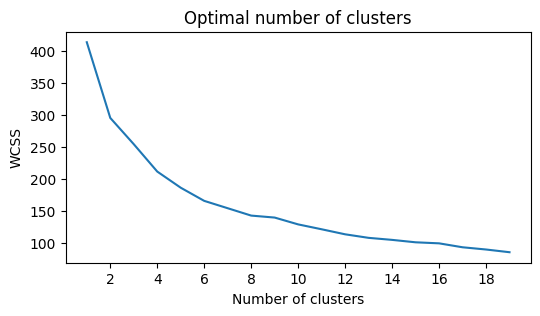

In [7]:
X_concrete_compressive_strength = load_from_uci(id=165) 
X_concrete_compressive_strength = transform_data(X_concrete_compressive_strength)

describe_dataset(X_concrete_compressive_strength)

The optimal number of clusters was selected as **6**

In [ ]:
# ~15min
results_concrete_compressive_strength = evaluation_workflow_single(
    df=X_concrete_compressive_strength,
    df_name="concrete", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=6, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/01_concrete.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.07 sec)
        Imputer: FCMParameterImputer (took 0.06 sec)
        Imputer: FCMRoughParameterImputer (took 0.06 sec)
        Imputer: FCMKIterativeImputer (took 0.60 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.12 sec)
        Imputer: FCMDTIterativeImputer (took 0.15 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNImputer (took 0.01 sec)
        Imputer: IterativeImputer (took 0.05 sec)
    Missing fraction: 0.05
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.07 sec)
        Imputer: FCMParameterImputer (took 0.09 sec)
        Imputer: FCMRoughParameterImputer (took 0.07 sec)
        Imputer: FCMKIterativeImputer (took 3.05 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.25 sec)
        Imputer: FCMDTIterativeImputer (took 0.82 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNIm

### **Glass**

Dataset Description:
--------------------
Number of samples: 214
Number of features: 9


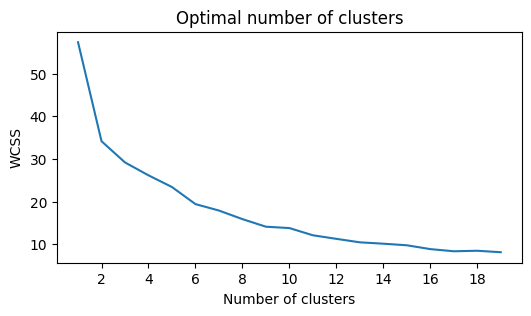

In [9]:
X_glass_identification = load_from_uci(id=42) 
X_glass_identification = transform_data(X_glass_identification)

describe_dataset(X_glass_identification)

The optimal number of clusters was selected as **5**

In [ ]:
# ~4min
results_glass = evaluation_workflow_single(
    df=X_glass_identification,
    df_name="glass", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=5, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/02_glass.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.01 sec)
        Imputer: FCMParameterImputer (took 0.02 sec)
        Imputer: FCMRoughParameterImputer (took 0.01 sec)
        Imputer: FCMKIterativeImputer (took 0.17 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.06 sec)
        Imputer: FCMDTIterativeImputer (took 0.06 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNImputer (took 0.01 sec)
        Imputer: IterativeImputer (took 0.02 sec)
    Missing fraction: 0.05
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.01 sec)
        Imputer: FCMParameterImputer (took 0.02 sec)
        Imputer: FCMRoughParameterImputer (took 0.00 sec)
        Imputer: FCMKIterativeImputer (took 1.11 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.08 sec)
        Imputer: FCMDTIterativeImputer (took 0.25 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNIm

### **Ionosphere**

Dataset Description:
--------------------
Number of samples: 351
Number of features: 34


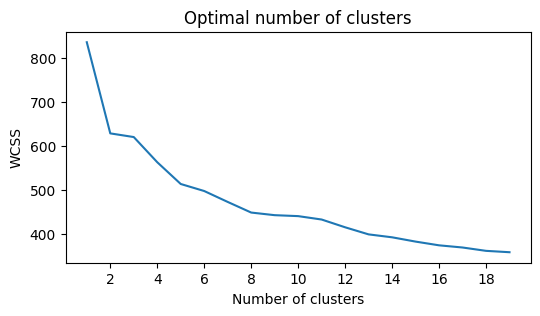

In [11]:
X_ionosphere = load_from_uci(id=52) 
X_ionosphere = transform_data(X_ionosphere)

describe_dataset(X_ionosphere)

The optimal number of clusters was selected as **8**

In [ ]:
# ~35min
results_ionosphere = evaluation_workflow_single(
    df=X_ionosphere,
    df_name="ionosphere", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=8, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/03_ionosphere.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.17 sec)
        Imputer: FCMParameterImputer (took 0.18 sec)
        Imputer: FCMRoughParameterImputer (took 0.17 sec)
        Imputer: FCMKIterativeImputer (took 3.84 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.12 sec)
        Imputer: FCMDTIterativeImputer (took 0.40 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNImputer (took 0.01 sec)
        Imputer: IterativeImputer (took 0.98 sec)
    Missing fraction: 0.05
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.06 sec)
        Imputer: FCMParameterImputer (took 0.05 sec)
        Imputer: FCMRoughParameterImputer (took 0.03 sec)
        Imputer: FCMKIterativeImputer (took 30.65 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.93 sec)
        Imputer: FCMDTIterativeImputer (took 8.17 sec)
        Imputer: MeanImputer (took 0.01 sec)
        Imputer: KNNI

### **Sonar**

Dataset Description:
--------------------
Number of samples: 208
Number of features: 60


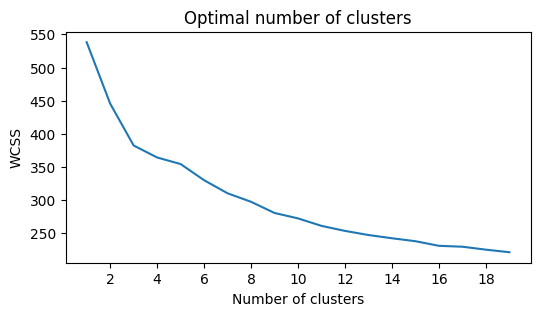

In [13]:
X_connectionist_bench_sonar_mines_vs_rocks = load_from_uci(id=151) 
X_connectionist_bench_sonar_mines_vs_rocks = transform_data(X_connectionist_bench_sonar_mines_vs_rocks)

describe_dataset(X_connectionist_bench_sonar_mines_vs_rocks)

The optimal number of clusters was selected as **8**

In [ ]:
# ~60min
results_sonar = evaluation_workflow_single(
    df=X_connectionist_bench_sonar_mines_vs_rocks,
    df_name="sonar", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=8, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/04_sonar.csv")

🔁 Repeat 1/10
    Missing fraction: 0.01
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.03 sec)
        Imputer: FCMParameterImputer (took 0.02 sec)
        Imputer: FCMRoughParameterImputer (took 0.01 sec)
        Imputer: FCMKIterativeImputer (took 6.26 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.02 sec)
        Imputer: FCMDTIterativeImputer (took 0.84 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNImputer (took 0.01 sec)
        Imputer: IterativeImputer (took 5.67 sec)
    Missing fraction: 0.05
        Random state: 43
        Imputer: FCMCentroidImputer (took 0.02 sec)
        Imputer: FCMParameterImputer (took 0.03 sec)
        Imputer: FCMRoughParameterImputer (took 0.02 sec)
        Imputer: FCMKIterativeImputer (took 16.79 sec)
        Imputer: FCMInterpolationIterativeImputer (took 0.05 sec)
        Imputer: FCMDTIterativeImputer (took 3.18 sec)
        Imputer: MeanImputer (took 0.00 sec)
        Imputer: KNNI

### **Wine Quality**

In [ ]:
X_wine_quality = load_from_uci(id=186) 
X_wine_quality = transform_data(X_wine_quality)

describe_dataset(X_wine_quality)

The optimal number of clusters was selected as **6**

In [ ]:
results_wine_quality = evaluation_workflow_single(
    df=X_wine_quality,
    df_name="wine_quality", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=6, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/05_wine_quality.csv")

### **Statalog**

In [ ]:
X_statlog_shuttle = load_from_uci(id=148) 
X_statlog_shuttle = transform_data(X_statlog_shuttle)

describe_dataset(X_statlog_shuttle)

The optimal number of clusters was selected as **4**

In [ ]:
results_statlog_shuttle = evaluation_workflow_single(
    df=X_statlog_shuttle,
    df_name="statlog", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=4, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/06_statlog.csv")

### **Credit Card**

In [ ]:
X_default_of_credit_card_clients = load_from_uci(id=350) 
X_default_of_credit_card_clients = transform_data(X_default_of_credit_card_clients)

describe_dataset(X_default_of_credit_card_clients)

The optimal number of clusters was selected as **2**

In [ ]:
results_default_of_credit_card_clients = evaluation_workflow_single(
    df=X_default_of_credit_card_clients,
    df_name="credit_card", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=2, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/07_credit_card.csv")

### **Skin**

In [ ]:
X_skin_segmentation = load_from_uci(id=229) 
X_skin_segmentation = transform_data(X_skin_segmentation)

describe_dataset(X_skin_segmentation)

The optimal number of clusters was selected as **4**

In [ ]:
results_skin_segmentation = evaluation_workflow_single(
    df=X_skin_segmentation,
    df_name="skin", 
    imputers=imputers, 
    missing_fractions=missing_fractions, 
    n_clusters=4, 
    n_repeats=n_repeats, 
    output_csv_path="01_MI_results/08_skin.csv")

## Results

In [5]:
def summarize_results(results_df):
    metric_cols = [col for col in results_df.columns 
                   if col.endswith("_RMSE")] #or col.endswith("_MAE")]
    
    # agg_dict = {col: ["mean", "std"] for col in metric_cols}
    agg_dict = {col: ["mean"] for col in metric_cols}

    summary = (
        results_df
        .groupby("Missing Fraction")
        .agg(agg_dict)
    )

    summary.columns = [
        f"{col}_{stat}" for col, stat in summary.columns
    ]
    
    summary = summary.round(4)

    return summary

In [ ]:
results_concrete = pd.read_csv("01_MI_results/concrete.csv")
summary_concrete = summarize_results(results_concrete)
summary_concrete

In [ ]:
results_glass = pd.read_csv("01_MI_results/glass.csv")
summary_glass = summarize_results(results_glass)
summary_glass

In [ ]:
results_ionosphere = pd.read_csv("01_MI_results/ionosphere.csv")
summary_ionosphere = summarize_results(results_ionosphere)
summary_ionosphere

In [ ]:
results_sonar = pd.read_csv("01_MI_results/sonar.csv")
summary_sonar = summarize_results(results_sonar)
summary_sonar

In [ ]:
results_wine_quality = pd.read_csv("01_MI_results/wine_quality.csv")
summary_wine_quality = summarize_results(results_wine_quality)
summary_wine_quality

In [ ]:
results_statalog = pd.read_csv("01_MI_results/statlog.csv")
summary_statalog = summarize_results(results_statalog)
summary_statalog

In [ ]:
results_credit_card = pd.read_csv("01_MI_results/credit_card.csv")
summary_credit_card = summarize_results(results_credit_card)
summary_credit_card

In [ ]:
results_skin = pd.read_csv("01_MI_results/skin.csv")
summary_skin = summarize_results(results_skin)
summary_skin